## 프로젝트 기반 빅데이터 서비스 솔루션 개발 전문 과정

#### 교과목명 : 머신러닝알고리즘 이해 및 활용
- 평가일 : 03.10
- 성명 :이재호
- 점수 :55(5.5/10)

Q1. iris data를 불러와서 아래 사항을 수행하세요.(15점)

- 결정트리 모델을 시각화하고 주요한 인사이트를 기술하세요.(tree.plot_tree or tree.export_graphviz 이용)
- Feature importance를 추출하고 시각화하세요.

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
dt_clf = DecisionTreeClassifier(random_state=156)
iris_data = load_iris()
iris_data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [6]:
X_train,X_test,y_train,y_test = train_test_split(iris_data.data, iris_data.target, test_size=0.2, random_state=11)
dt_clf.fit(X_train,y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
clf_report = classification_report(y_test, pred)

print(f'결정트리예측정확도: {accuracy:.4f}','\n')
print(f'classification report: {clf_report}')

결정트리예측정확도: 0.9333 

classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.83      1.00      0.91        10
           2       1.00      0.82      0.90        11

    accuracy                           0.93        30
   macro avg       0.94      0.94      0.94        30
weighted avg       0.94      0.93      0.93        30



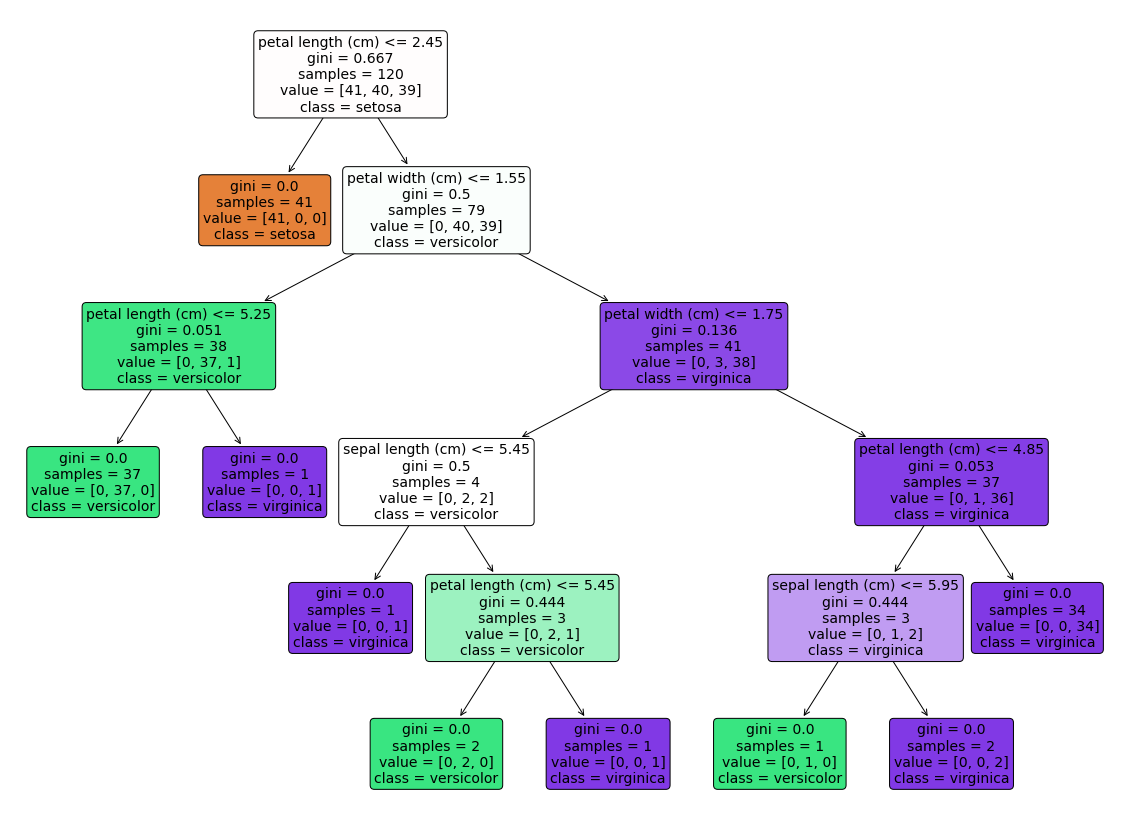

In [7]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
tree.plot_tree(dt_clf, filled=True,
              feature_names = iris_data.feature_names,
              class_names = iris_data.target_names,
              rounded=True, fontsize=14)

plt.show()
plt.close()

Feature importances: 
[0.025 0.    0.555 0.42 ] 

sepal length (cm):0.025
sepal width (cm):0.000
petal length (cm):0.555
petal width (cm):0.420


<AxesSubplot:>

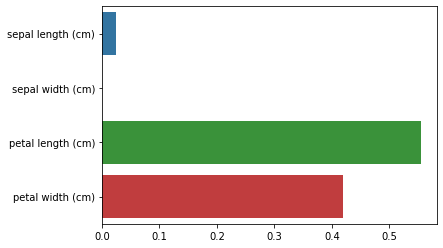

In [10]:
import seaborn as sns
import numpy as np
%matplotlib inline

print(f'Feature importances: \n{np.round(dt_clf.feature_importances_,3)}','\n')

for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print(f'{name}:{value:.3f}')
    
sns.barplot(x=dt_clf.feature_importances_,y=iris_data.feature_names)

Q2~Q3. 'dataset/creditcard.csv'를 불러와서 신용카드 사기 검출 분류문제를 아래와 같이 수행하세요(10점)
- 로지스틱 리그레션을 적용한 모델 학습 및 사용자 함수를 이용하여 평가
    - 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 df 반환하는 사용자 함수 생성
    - 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수(테스트 사이즈 0.3)
    - 오차행렬, 정확도, 정밀도, 재현율, f1, AUC 평가 함수
    
- 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서  학습/예측/평가 수행
    - 사용자 함수를 사용하여 LightGBM으로 모델을 학습한 뒤 별도의 테스트 데이터 세트에서 예측 평가를 수행. 단, n_estimators=1000, num_leaves=64 적용<br>  ※ 레이블 값이 극도로 불균형한 분포를 가지고 있는 경우 boost_from_average=False로 파라미터 설정(default=True). default 설정은 재현율, AUC 성능을 매우 크게 저하시킴
    - 넘파이의 np.log1p( )를 이용하여 Amount를 로그 변환하는하는 사용자 함수 생성
    - Amount를 로그 변환 후 로지스틱 회귀 및 LightGBM 수행.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./datasets/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1_score: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [23]:
from sklearn.model_selection import train_test_split


def get_preprocessed_df(df=None):
    df_copy=df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [24]:

def get_train_test_dataset(df=None):

    df_copy = get_preprocessed_df(df)

    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]

    X_train,X_test,y_train,y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

    return X_train, X_test, y_train,y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [25]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [26]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

# 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85283    12]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8846, 재현율: 0.6216,    F1_score: 0.7302, AUC:0.9640


In [27]:

def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred= model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [28]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1_score: 0.8453, AUC:0.9790


In [29]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [30]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf,ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,
                    tgt_test = y_test)

print('### LightGBM 예측 성능###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test= y_test)

### 로지스틱 회귀 예측 성능###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1_score: 0.7143, AUC:0.9702
### LightGBM 예측 성능###
오차 행렬
[[85260    35]
 [   68    80]]
정확도: 0.9988, 정밀도: 0.6957, 재현율: 0.5405,    F1_score: 0.6084, AUC:0.7700


In [31]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [32]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf,ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,
                    tgt_test = y_test)

print('### LightGBM 예측 성능###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test= y_test)

### 로지스틱 회귀 예측 성능###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1_score: 0.7149, AUC:0.9727
### LightGBM 예측 성능###
오차 행렬
[[85174   121]
 [  148     0]]
정확도: 0.9969, 정밀도: 0.0000, 재현율: 0.0000,    F1_score: 0.0000, AUC:0.4992


Q4. Q2 신용카드 사기 검출 분류문제에서 아래를 참고하여 이상치 데이터를 제거하고 모델 학습/예측/평가를 수행하세요(5점)
- 히트맵을 이용해 레이블과의 상관성을 시각화 
- 레이블과 상관성이 높은 피처를 위주로 이상치 검출하는 사용자 함수 생성
- 사용자 함수를 이용하여 이상치 검출
- 이상치 제거 사용자 함수를 이용하여 이상치 제거 후 로지스틱 회귀 및 LightGBM 수행 및 평가

<AxesSubplot:>

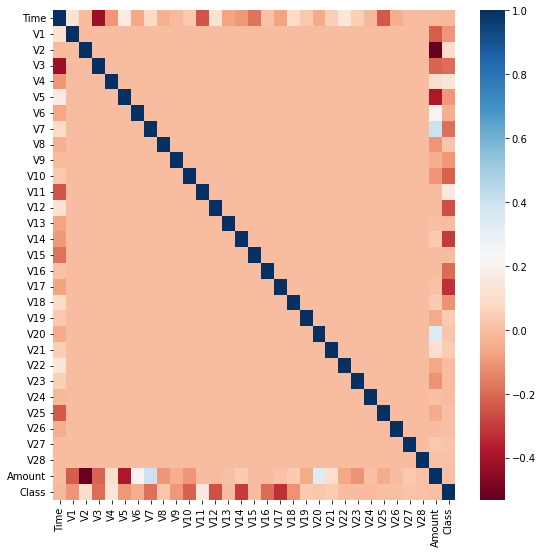

In [33]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [46]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values,25)
    quantile_75 = np.percentile(fraud.values,75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [47]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [48]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test,y_train,y_test = get_train_test_dataset(card_df)
print('###로지스틱 회귀 예측 성능###')
get_model_train_eval(lr_clf,ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,
                    tgt_test = y_test)
print('###LightGBM 예측 성능###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test = X_test, tgt_train=y_train, tgt_test=y_test)

###로지스틱 회귀 예측 성능###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1_score: 0.7597, AUC:0.9743
###LightGBM 예측 성능###
오차 행렬
[[85268    27]
 [   36   110]]
정확도: 0.9993, 정밀도: 0.8029, 재현율: 0.7534,    F1_score: 0.7774, AUC:0.9219


Q5. SMOTE 오버 샘플링 적용 후 LightGBM 모델을 이용하여 학습, 예측, 평가를 수행하세요.(10점)

In [50]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용전 학습용 피처/레이블 데이터 세트:', X_train.shape,y_train.shape)
print('SMOTE 적용후 학습용 피처/레이블 데이터 세트:', X_train_over.shape,y_train_over.shape)
print('SMOTE 적용후 레이블 값 분포:\n',pd.Series(y_train_over).value_counts())

SMOTE 적용전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용후 레이블 값 분포:
 0    199020
1    199020
Name: Class, dtype: int64


Q6. 사이킷런에서 제공해주는 load_boston 데이터셋을 가져와서 아래 사항을 수행하세요.(10점)
- 데이터셋의 타겟 이름을 'PRICE'로 지정한 후 데이터프레임을 생성 pickle 파일로 저장 후 다시 불어오세요.
- 히트맵을 이용하여 타겟과 상관관계가 높은 독립 변수를 선택하세요.
- 종속변수를 로그 변환하세요
- 위의 사항을 반영하여 선회회귀 모델을 생성 후 평가하고 회귀계수를 출력하세요.

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

boston = load_boston()
boston_df = pd.DataFrame(boston.data,columns = boston.feature_names)
boston_df['PRICE'] = boston.target
print('Boston 데이터 세트 크키:', boston_df.shape)
boston_df.head()

Boston 데이터 세트 크키: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


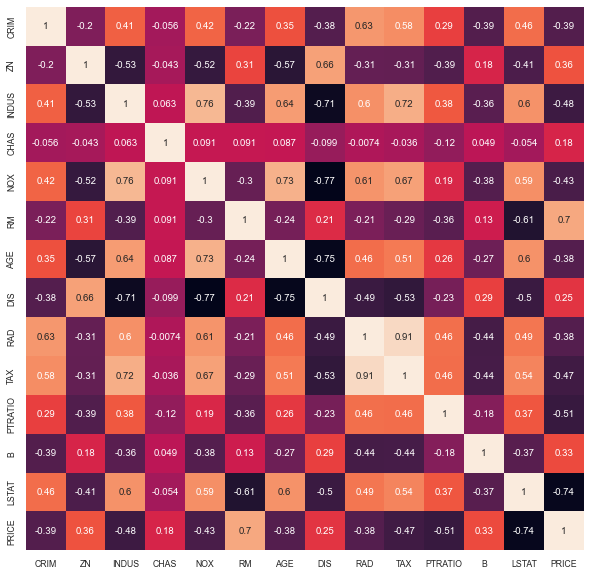

In [70]:
boston_df_corr=boston_df.corr()

#히트맵
plt.figure(figsize=(10,10))
sns.set(font_scale=0.8)
sns.heatmap(boston_df_corr, annot=True, cbar=False)
plt.show()

In [81]:
corr_order = boston_df.corr().loc[:'LSTAT','PRICE'].abs().sort_values(ascending=False)
corr_order.head(8)

LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.388305
RAD        0.381626
Name: PRICE, dtype: float64

Q7. house_df.pkl 데이터셋을 불러와서 아래사항을 수행하세요.(15점)
- alphas = [0, 0.1, 1, 10, 100] 를 적용하여 Ridge 회귀 모델링 및 교차 검증 수행 후 5 폴드 평균 RMSE 출력 
- lasso_alphas = [0.07,0.1,0.5,1,3] 를 적용, Lasso 회귀 모델링 및 교차 검증 수행 후 5 폴드 평균 RMSE 출력(def get_linear_reg_eval(model_name,params=None,X_data_n=None, y_target_n=None, verbose=True 사용자 함수 이용) 
- elastic_alphas = [0.07,0.1,0.5,1,3] 를 적용, ElasticNet 회귀 모델링 및 교차검증 후 5 폴드 평균 RMSE를 출력(사용자 함수 이용)

Q8. load_boston 데이터셋을 불러와서 다음사항을 수행하세요.
- SVM 알고리즘을 활용한 주택가격 예측모델 생성 및 평가(MSE, RMSE, R2)
- 개발된 예측모델을 활용하여 아래 test_data가 주어졌은때의 주택가격 예측<br>
test_data = [3.7, 0, 18.4, 1, 0.87, 5.95, 91, 2.5052, 26, 666, 20.2, 351.34, 15.27]

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

boston = load_boston()
boston_df = pd.DataFrame(boston.data,columns = boston.feature_names)
boston_df['PRICE'] = boston.target
print('Boston 데이터 세트 크키:', boston_df.shape)
boston_df.head()

Boston 데이터 세트 크키: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [80]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = boston_df['PRICE']
X_data = boston_df.drop(['PRICE'],axis=1, inplace=False)

X_train,X_test,y_train,y_test = train_test_split(X_data, y_target, test_size=0.3,random_state=156)

lr = LinearRegression()
lr.fit(X_train,y_train)

y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test,y_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_preds)
print(f'mse: {mse},rmse: {rmse},r2: {r2}')

mse: 17.296915907902054,rmse: 4.158956107955704,r2: 0.7572263323138935


Q9. mtcars 데이터셋(mtcars.csv)의 qsec 컬럼을 최소최대 척도(Min-Max Scale)로 변환한 후 0.5보다 
큰 값을 가지는 레코드 수를 구하시오

Q10. purdata.csv는 백화점 고객의 1년 간 구매 데이터이다. 아래사항을 수행하세요.
 
- 남성고객을 분류하는 모델을 생성(분류알고리즘 : dt,rf,lr)
- 모델 성능을 roc_auc로 평가 